In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import plotly.graph_objects as go
import re
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [91]:
data = pd.read_csv('cleaned_data.csv')
data.head()

CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN         Mobile Phone         1              8.0   
2       50003      1     NaN         Mobile Phone         1             30.0   
3       50004      1     0.0         Mobile Phone         3             15.0   
4       50005      1     0.0         Mobile Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4          Credit Card    Male             NaN                         3   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
0  Laptop & Accessory                  2        Single                9   
1        Mobile Phone                  3        Single                7   
2        Mobile Phone                  3        Single                6   
3  Laptop & Accessory                  5        Single                8   
4        Mobile Phone                  5        Single                3   

   Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
0         1                         11.0         1.0         1.0   
1         1                         15.0         0.0         1.0   
2         1                         14.0         0.0         1.0   
3         0                         23.0         0.0         1.0   
4         0                         11.0         1.0         1.0   

   DaySinceLastOrder  CashbackAmount  
0                5.0          159.93  
1                0.0          120.90  
2                3.0          120.28  
3                3.0          134.07  
4                3.0          129.60

### EDA

Stages of EDA that will be carried out:

- Correlation testing to find out which features have a strong influence on the label (Churn)
- Information from the proportion of each feature to the label (Churn) to see its characteristics
- Characteristics and factors that influence the label (Churn)

## Data Preprocessing

### Dropping irrelevant columns
- There are several considerations in dropping columns. To find out which columns will be dropped, we use domain knowledge to decide which features are considered irrelevant.

Based on domain knowledge, the 'CustomerID' column has no relevance and importance for predictive analysis.


In [92]:
##data.drop(columns=['CustomerID'], inplace=True)

### Handling Duplicate Value
- At this stage, a merge will be carried out for features that have the same value but there are differences in their writing.

In [3]:
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  0


### Handling Missing Value

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   int64  
 1   Tenure                       5366 non-null   float64
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   int64  
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   int64  
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   int64  
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   int64  
 13  Complain          

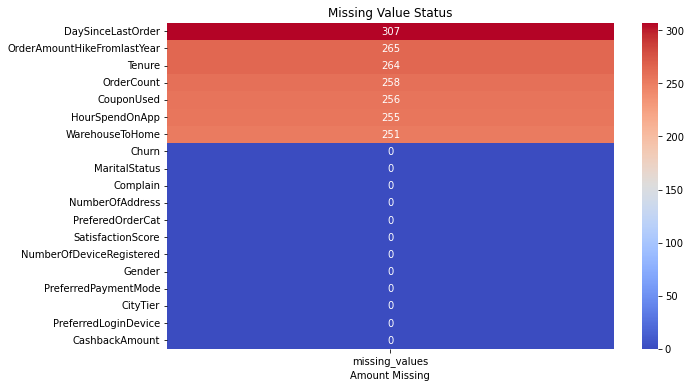

In [23]:
missing_distribution = data.isna().sum().to_frame(name='missing_values')

plt.figure(figsize=(10,6))
plt.title('Missing Value Status')
ax = sns.heatmap(missing_distribution.sort_values(by='missing_values', ascending=False), annot=True, fmt='d', cmap = 'coolwarm')
ax.set_xlabel('Amount Missing')
plt.show()

In [27]:
(data.isnull().sum()/len(data) * 100).sort_values(ascending=False)

DaySinceLastOrder              5.452931
OrderAmountHikeFromlastYear    4.706927
Tenure                         4.689165
OrderCount                     4.582593
CouponUsed                     4.547069
HourSpendOnApp                 4.529307
WarehouseToHome                4.458259
Churn                          0.000000
MaritalStatus                  0.000000
Complain                       0.000000
NumberOfAddress                0.000000
PreferedOrderCat               0.000000
SatisfactionScore              0.000000
NumberOfDeviceRegistered       0.000000
Gender                         0.000000
PreferredPaymentMode           0.000000
CityTier                       0.000000
PreferredLoginDevice           0.000000
CashbackAmount                 0.000000
dtype: float64

It can be seen that there are 7 features that have missing values with a percentage of > 4%, so adjustments must be made so that there are no problems for the model. Before deciding how to solve it, we must first know the potential causes of the missing data.

##### **Missing Value : DaySinceLastOrder**

In [28]:
data["DaySinceLastOrder"].unique()

array([ 5.,  0.,  3.,  7.,  2.,  1.,  8.,  6.,  4., 15.,  9., 11., 10.,
       nan, 13., 12., 17., 16., 14., 30., 46., 18., 31.])

DaySinceLastOrder is the range of days since the last transaction, the value 'nan' could be because the customer is new or the customer is making a transaction for the first time. Therefore, to prove this assumption, a check is carried out on the total orders that have been made for the missing DaySinceLastOrder data.

In [29]:
data_null = data[data['DaySinceLastOrder'].isna()].copy()
data_null

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
88        0    24.0         Mobile Phone         1             14.0   
97        0    10.0             Computer         1             17.0   
126       0    12.0             Computer         1              8.0   
146       1    10.0             Computer         1             35.0   
151       0     2.0         Mobile Phone         1             28.0   
...     ...     ...                  ...       ...              ...   
5591      0     6.0         Mobile Phone         3              8.0   
5608      0    15.0         Mobile Phone         3             10.0   
5610      0     9.0         Mobile Phone         2             33.0   
5623      0     5.0             Computer         1             12.0   
5626      0    13.0         Mobile Phone         1             13.0   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
88             Debit Card    Male             2.0                         4   
97                    UPI    Male             2.0                         3   
126      Cash on Delivery  Female             3.0                         3   
146            Debit Card    Male             2.0                         3   
151            Debit Card  Female             3.0                         2   
...                   ...     ...             ...                       ...   
5591             E wallet  Female             3.0                         4   
5608           Debit Card    Male             3.0                         5   
5610           Debit Card  Female             3.0                         4   
5623          Credit Card    Male             4.0                         4   
5626          Credit Card    Male             3.0                         5   

        PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
88               Fashion                  4      Divorced                6   
97               Fashion                  2       Married                2   
126              Fashion                  3        Single                1   
146              Fashion                  4      Divorced                2   
151              Fashion                  4       Married                8   
...                  ...                ...           ...              ...   
5591             Fashion                  1       Married                3   
5608  Laptop & Accessory                  4       Married                4   
5610             Fashion                  1        Single                3   
5623  Laptop & Accessory                  5        Single                2   
5626             Fashion                  5       Married                6   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
88           0                         16.0         1.0         4.0   
97           1                         14.0         0.0         1.0   
126          0                         25.0        10.0        11.0   
146          1                         12.0         5.0         9.0   
151          0                         18.0         5.0         6.0   
...        ...                          ...         ...         ...   
5591         0                         20.0         1.0         6.0   
5608         0                         12.0         2.0         2.0   
5610         1                         17.0         2.0         2.0   
5623         0                         20.0         2.0         2.0   
5626         0                         16.0         1.0         2.0   

      DaySinceLastOrder  CashbackAmount  
88                  NaN          224.90  
97                  NaN          221.85  
126                 NaN          209.38  
146                 NaN          218.49  
151                 NaN          219.96  
...                 ...             ...  
5591                NaN          229.22  
5608                NaN          214.38  
5610                NaN          213

In [38]:
data_null[data_null['OrderCount']<1 | data_null['OrderCount'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

It can be seen that for the missing DaySinceLastOrder values, all have ordercount values >= 1. This means that the data does not represent new customers or customers who are making their first transaction. It is possible that the missing value is caused by data not being inputted.

##### **Missing Value : OrderAmountHikeFromlastYear**

In [33]:
data["OrderAmountHikeFromlastYear"].unique()

array([11., 15., 14., 23., 22., 16., 12., nan, 13., 17., 18., 24., 19.,
       20., 21., 25., 26.])

OrderAmountHikeFromlastYear is the increase in the percentage of transactions from last year, the 'nan' value could be because the customer is new or the customer is making a transaction for the first time. Therefore, to prove this assumption, a check is carried out on the total orders that have been made for the missing OrderAmountHikeFromlastYear data.

In [35]:
data_null = data[data['OrderAmountHikeFromlastYear'].isna()].copy()
data_null

Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
10        1     4.0         Mobile Phone         1             18.0   
40        0    23.0         Mobile Phone         1             17.0   
65        0    25.0         Mobile Phone         1              6.0   
106       0    15.0         Mobile Phone         1             10.0   
108       0    23.0         Mobile Phone         3              6.0   
...     ...     ...                  ...       ...              ...   
5534      0    61.0         Mobile Phone         3             28.0   
5537      0    23.0             Computer         1              9.0   
5561      0    29.0         Mobile Phone         2             33.0   
5597      0    13.0             Computer         1             16.0   
5603      0    16.0         Mobile Phone         1              9.0   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
10       Cash on Delivery  Female             2.0                         3   
40             Debit Card  Female             2.0                         3   
65             Debit Card    Male             3.0                         4   
106      Cash on Delivery    Male             2.0                         3   
108           Credit Card  Female             3.0                         3   
...                   ...     ...             ...                       ...   
5534           Debit Card  Female             4.0                         4   
5537           Debit Card    Male             3.0                         4   
5561                  UPI    Male             4.0                         2   
5597           Debit Card    Male             3.0                         4   
5603           Debit Card    Male             3.0                         4   

     PreferedOrderCat  SatisfactionScore MaritalStatus  NumberOfAddress  \
10             Others                  3      Divorced                2   
40             Others                  4        Single                4   
65             Others                  3      Divorced                1   
106            Others                  2      Divorced                2   
108            Others                  2       Married                4   
...               ...                ...           ...              ...   
5534          Grocery                  1       Married                6   
5537           Others                  1       Married                5   
5561           Others                  4       Married                6   
5597           Others                  1        Single                4   
5603           Others                  3       Married                7   

      Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
10           0                          NaN         9.0        15.0   
40           0                          NaN         2.0         4.0   
65           0                          NaN         1.0        11.0   
106          0                          NaN         0.0        11.0   
108          0                          NaN         1.0         1.0   
...        ...                          ...         ...         ...   
5534         1                          NaN         1.0         2.0   
5537         0                          NaN         5.0         5.0   
5561         1                          NaN         2.0         2.0   
5597         0                          NaN         2.0         2.0   
5603         0                          NaN         1.0         5.0   

      DaySinceLastOrder  CashbackAmount  
10                  8.0          295.45  
40                  4.0          299.26  
65                  9.0          299.99  
106                15.0          292.32  
108                 6.0          295.17  
...                 ...             ...  
5534                1.0          303.75  
5537                4.0          316.61  
5561                5.0          321.36  
5597                4.0       

In [37]:
data_null[data_null['OrderCount']<1 | data_null['OrderCount'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

It can be seen that for the missing OrderAmountHikeFromlastYear values, all have ordercount values ​​>= 1. This means that the data does not represent new customers or customers who are making their first transaction. It is possible that the missing value is caused by the data not being inputted.

##### **Missing Value : Tenure**

In [41]:
data["Tenure"].unique()

array([ 4., nan,  0., 13., 11.,  9., 19., 20., 14.,  8., 18.,  5.,  2.,
       30.,  1., 23.,  3., 29.,  6., 26., 28.,  7., 24., 25., 10., 15.,
       22., 27., 16., 12., 21., 17., 50., 60., 31., 51., 61.])

Tenure is the subscription period of a customer. New customers are represented with a value of 0, possibly a 'nan' value because it was not inputted.

##### **Missing Value : OrderCount**

In [44]:
data["OrderCount"].unique()

array([ 1.,  6.,  2., 15.,  4.,  7.,  3.,  9., nan, 11.,  5., 12., 10.,
        8., 13., 14., 16.])

OrderCount is the total order in the last month, the value of 'nan' could be because the customer is new or the customer has just made a transaction for the first time. Therefore, to prove this assumption, a check is carried out on the increase in transactions made for the missing OrderCount data.

In [46]:
data_null = data[data['OrderCount'].isna()].copy()
data_null[data_null['OrderAmountHikeFromlastYear']<1 | data_null['OrderAmountHikeFromlastYear'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

It can be seen that for the missing OrderCount values, all have OrderAmountHikeFromlastYear values ​​> 1. This means that the data does not represent new customers or customers who are making their first transaction. It is possible that the missing value is caused by the data not being inputted.

##### **Missing Value : CouponUsed**

In [48]:
data["CouponUsed"].unique()


array([ 1.,  0.,  4.,  2.,  9.,  6., 11., nan,  7., 12., 10.,  5.,  3.,
       13., 15.,  8., 14., 16.])

In [49]:
data_null = data[data['CouponUsed'].isna()].copy()
data_null[data_null['OrderCount']<1 | data_null['OrderCount'].isna()]

Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount]
Index: []

It can be seen that for the missing CouponUsed values, all have ordercount values >= 1. This means that the data does not represent new customers or customers who are making their first transaction. It is possible that the missing value is caused by data not being inputted.

##### **Missing Value : HourSpendOnApp**

In [53]:
data["HourSpendOnApp"].unique()

array([ 3.,  2., nan,  1.,  0.,  4.,  5.])

HourSpendOnApp is the length of time a customer is online in the application. New customers are represented with a value of 0, possibly a 'nan' value because it was not inputted.

##### **Missing Value : WarehouseToHome**

In [57]:
data["WarehouseToHome"].unique()

array([  6.,   8.,  30.,  15.,  12.,  22.,  11.,   9.,  31.,  18.,  13.,
        20.,  29.,  28.,  26.,  14.,  nan,  10.,  27.,  17.,  23.,  33.,
        19.,  35.,  24.,  16.,  25.,  32.,  34.,   5.,  21., 126.,   7.,
        36., 127.])

Warehouse Home is the distance from the warehouse to the customer address, possibly a 'nan' value because it was not inputted or order was not placed.

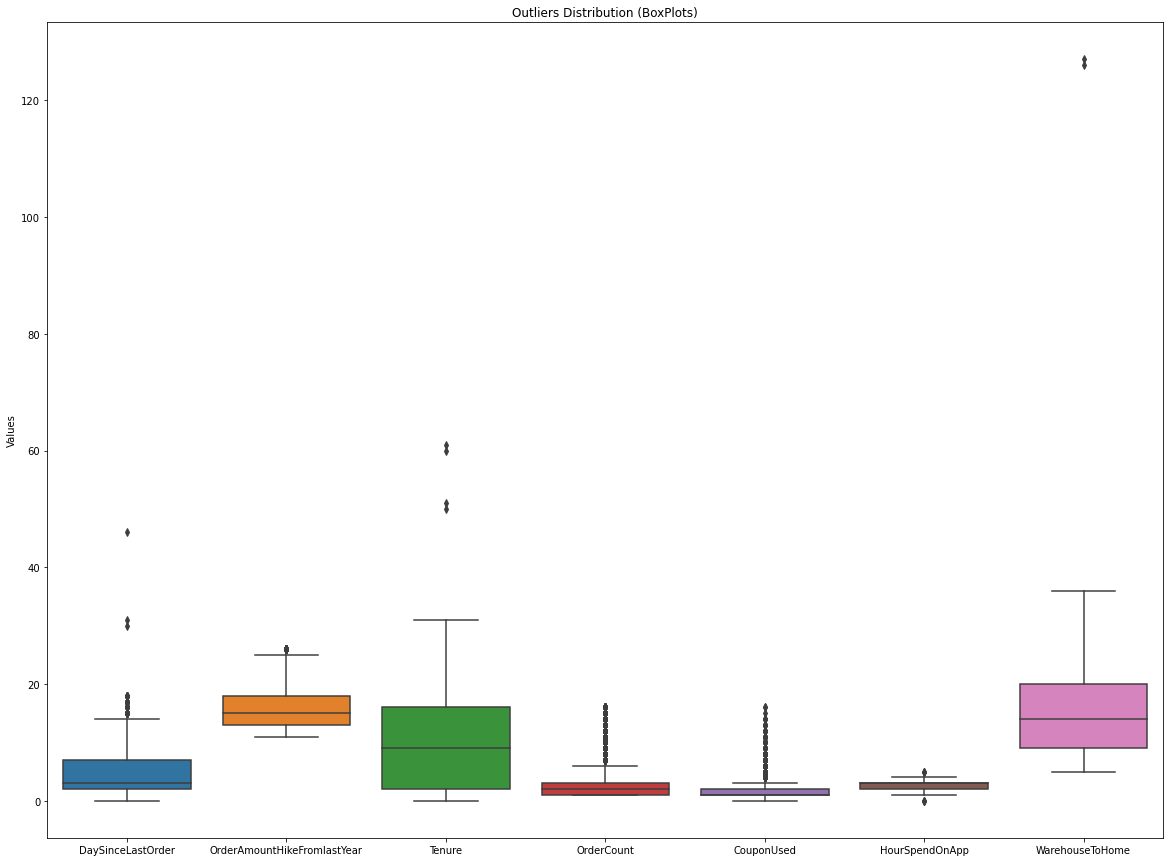

In [93]:
missing_cols = ['DaySinceLastOrder','OrderAmountHikeFromlastYear','Tenure','OrderCount','CouponUsed','HourSpendOnApp','WarehouseToHome']

plt.figure(figsize=(20,15))
sns.boxplot(data=data[missing_cols])
plt.title('Outliers Distribution (BoxPlots)')
plt.ylabel('Values')
plt.show()

In [68]:
data[missing_cols].describe().T

count       mean       std   min   25%   50%  \
DaySinceLastOrder            5323.0   4.543491  3.654433   0.0   2.0   3.0   
OrderAmountHikeFromlastYear  5365.0  15.707922  3.675485  11.0  13.0  15.0   
Tenure                       5366.0  10.189899  8.557241   0.0   2.0   9.0   
OrderCount                   5372.0   3.008004  2.939680   1.0   1.0   2.0   
CouponUsed                   5374.0   1.751023  1.894621   0.0   1.0   1.0   
HourSpendOnApp               5375.0   2.931535  0.721926   0.0   2.0   3.0   
WarehouseToHome              5379.0  15.639896  8.531475   5.0   9.0  14.0   

                              75%    max  
DaySinceLastOrder             7.0   46.0  
OrderAmountHikeFromlastYear  18.0   26.0  
Tenure                       16.0   61.0  
OrderCount                    3.0   16.0  
CouponUsed                    2.0   16.0  
HourSpendOnApp                3.0    5.0  
WarehouseToHome              20.0  127.0

From the graph and table above, it is found that the features that have missing values are features that have numeric values. For this reason, missing value handling will be carried out in several ways by considering the min - max value range, Q1 - Q3 range and the relationship between features will be adjusted to the missing value conditions of each feature, namely:

1. 'DaySinceLastOrder' has a value range of 0 - 46 and a range between Q1 to Q3 with a value of 2 - 7 and there are outliers in the data, by taking into account the width of the range between the minimum and maximum values and the relationship with other features, the missing value will be filled using the iterative imputer method with a regression model.

2. 'OrderAmountHikeFromlastYear' has a value range of 11 - 26 and a range between Q1 to Q3 with a value of 13 - 18 and there are outliers in the data, by taking into account the width of the range between the minimum and maximum values ​​and the relationship with other features, the missing value will be filled using the iterative imputer method with a regression model.

3. 'Tenure' has a range of values 0 - 61 and a range between Q1 to Q3 with a value of 2 - 16 and there are outliers in the data, by taking into account the width of the range between the minimum and maximum values and the relationship with other features, the missing value will be filled using the iterative imputer method with a regression model.

4. 'OrderCount' has a range of values 1 - 16 and a range between Q1 to Q3 with a value of 1 - 3 and there are outliers in the data, by taking into account the width of the range between the minimum and maximum values and the relationship with other features, the missing value will be filled using the iterative imputer method with a regression model.

5. 'CouponUsed' has a range of values 0 - 16 and a range between Q1 to Q3 with a value of 1 - 2 and there are outliers in the data, by taking into account the width of the range between the minimum and maximum values and the relationship with other features, the missing value will be filled using the iterative imputer method with a regression model.

6. 'HourSpendOnApp' has a range of values 0 - 5 and a range between Q1 to Q3 with a value of 2 - 3 and there are outliers in the data, considering the small range between the minimum and maximum values, the missing value will be filled using the simple imputer method with the median value.

7. 'WarehouseToHome' has a range of values 5 - 127 and a range between Q1 to Q3 with a value of 9 - 20 and there are outliers in the data, taking into account the width of the range between the minimum and maximum values and the relationship with other features, the missing value will be filled using the iterative imputer method with a regression model.

Iterative imputer is one method of filling in missing values that uses other features in the data to create a regression model to produce a value for the missing value.

For filling in missing values according to the explanation above, it will be done together with encoding using a transformer.

#### Handling Missing Values Imputation

In [94]:
cat_features = ['Tenure','WarehouseToHome','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder']
cont_features = ['HourSpendOnApp']

In [95]:
def imputation (data, 
                #x_test,
                cont_features,
                cat_features,
                cont_strategy = 'median',
                cat_strategy = 'most_frequent'
                ):

#initializing object imputer
  imputerCat = SimpleImputer(missing_values=np.nan, strategy= cat_strategy)
  imputerCont = SimpleImputer(missing_values=np.nan, strategy= cont_strategy)

#fit data
  imputerCont.fit(data[cont_features])
  imputerCat.fit(data[cat_features])

#transfrom data
  data[cont_features] = imputerCont.transform(data[cont_features])
  data[cat_features] = imputerCat.transform(data[cat_features])

  return data

In [96]:
data = imputation(data,cont_features, cat_features)
data

CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
0          50001      1     4.0         Mobile Phone         3   
1          50002      1     1.0         Mobile Phone         1   
2          50003      1     1.0         Mobile Phone         1   
3          50004      1     0.0         Mobile Phone         3   
4          50005      1     0.0         Mobile Phone         1   
...          ...    ...     ...                  ...       ...   
5625       55626      0    10.0             Computer         1   
5626       55627      0    13.0         Mobile Phone         1   
5627       55628      0     1.0         Mobile Phone         1   
5628       55629      0    23.0             Computer         3   
5629       55630      0     8.0         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
0                 6.0           Debit Card  Female             3.0   
1                 8.0                  UPI    Male             3.0   
2                30.0           Debit Card    Male             2.0   
3                15.0           Debit Card    Male             2.0   
4                12.0          Credit Card    Male             3.0   
...               ...                  ...     ...             ...   
5625             30.0          Credit Card    Male             3.0   
5626             13.0          Credit Card    Male             3.0   
5627             11.0           Debit Card    Male             3.0   
5628              9.0          Credit Card    Male             4.0   
5629             15.0          Credit Card    Male             3.0   

      NumberOfDeviceRegistered    PreferedOrderCat  SatisfactionScore  \
0                            3  Laptop & Accessory                  2   
1                            4        Mobile Phone                  3   
2                            4        Mobile Phone                  3   
3                            4  Laptop & Accessory                  5   
4                            3        Mobile Phone                  5   
...                        ...                 ...                ...   
5625                         2  Laptop & Accessory                  1   
5626                         5             Fashion                  5   
5627                         2  Laptop & Accessory                  4   
5628                         5  Laptop & Accessory                  4   
5629                         2  Laptop & Accessory                  3   

     MaritalStatus  NumberOfAddress  Complain  OrderAmountHikeFromlastYear  \
0           Single                9         1                         11.0   
1           Single                7         1                         15.0   
2           Single                6         1                         14.0   
3           Single                8         0                         23.0   
4           Single                3         0                         11.0   
...            ...              ...       ...                          ...   
5625       Married                6         0                         18.0   
5626       Married                6         0                         16.0   
5627       Married                3         1                         21.0   
5628       Married                4         0                         15.0   
5629       Married                4         0                         13.0   

      CouponUsed  OrderCount  DaySinceLastOrder  CashbackAmount  
0            1.0         1.0                5.0          159.93  
1            0.0         1.0                0.0          120.90  
2            0.0         1.0                3.0          120.28  
3            0.0         1.0                3.0          134.07  
4            1.0         1.0                3.0          129.60  
...          ...         ...                ...             ...  
5625         1.0         2.0                4.0          150.71  
5626         1.0         2.0  

## Segmentation Modelling:

Creating a a model that can perform customer segmentation. Customer segmentation itself is an unsupervised problem so our data is not labeled, but later we will provide the label ourselves. 

Algorithms used:

- RFM Sementation
- K-Means



### RFM Segmentation

RFM stands for Recency, Frequency, and Monetary. Each factor is adjusted to the characteristics of the customer. This RFM metric is an important indicator of customer behavioral segmentation because frequency and monetary affect customer lifetime value, and recency affects engagement rate.

Recency: Measures the last time a customer made a transaction.

Frequency: Measures how often a customer makes a transaction.

Monetary: Measures the total transactions made by a customer.

In [97]:
rfm_df = data.copy()
rfm_df = rfm_df.rename(columns={"DaySinceLastOrder": "recency", "OrderCount": "frequency", 'CashbackAmount':'monetary'})

#### Recency Segmentation
Recency is the calculation of the last time a customer made a transaction in days. Segmentation based on recency is done by creating groups based on quartile values ​​(Q1, Q2, and Q3) so that there are 4 groups. The names of these groups are active, warm, cold, and inactive which are taken based on market temperature.

**Scoring**

In [98]:
# Calculate Q1, Q2, Q3 from Recency
rfm_df['recency'].quantile([0.25, 0.5, 0.75])

0.25    2.0
0.50    3.0
0.75    7.0
Name: recency, dtype: float64

In [99]:
# Recency Segmentation using quartile and scoring
label_r = range(4, 0, -1)
group_r = pd.qcut(rfm_df['recency'], q=4, labels=label_r)
rfm_df['R'] = group_r.values

In [104]:
group_r.head()

0    2
1    4
2    3
3    3
4    3
Name: recency, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

In [100]:
rfm_df["R"].unique()

[2, 4, 3, 1]
Categories (4, int64): [4 < 3 < 2 < 1]

In [101]:
rfm_df[rfm_df['R'].isna()]

Empty DataFrame
Columns: [CustomerID, Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, PreferedOrderCat, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, frequency, recency, monetary, R]
Index: []

[0 rows x 21 columns]

In [102]:
# Group by R
df_R = rfm_df.groupby(['R']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop = False)

# Name the R segment
df_R.loc[df_R['R'] == 4, 'R_group'] = 'active'
df_R.loc[df_R['R'] == 3, 'R_group'] = 'warm'
df_R.loc[df_R['R'] == 2, 'R_group'] = 'cold'
df_R.loc[df_R['R'] == 1, 'R_group'] = 'innactive'

# Calculate the percentage
df_R['R_percent'] = round(df_R['n_customers']/df_R['n_customers'].sum()*100, 2)

df_R

R  n_customers    R_group  R_percent
0  4         1902     active      33.78
1  3         1207       warm      21.44
2  2         1219       cold      21.65
3  1         1302  innactive      23.13

- Active = Recency is less than or equal to 2 days (Q1)
- Warm = Recency is between 3 days (Q2)
- Cold = Recency is between 7 days (Q3)
- Inactive = Recency is more than 7 days (Q3)

**Visualization**

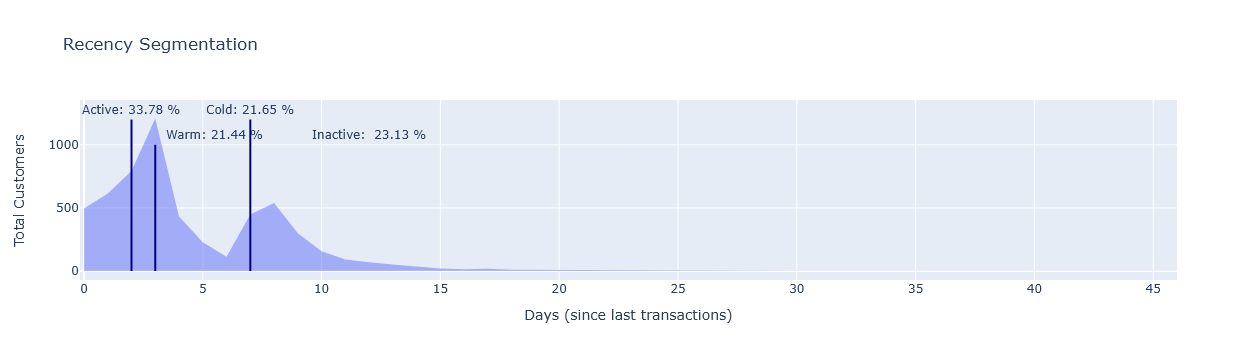

In [109]:
recency_cust = rfm_df['CustomerID'].groupby(rfm['recency']).count()

# Visualization
fig = go.Figure()
# Create Layout
fig.update_layout(
    title='Recency Segmentation',
    xaxis_title='Days (since last transactions)',
    yaxis_title='Total Customers',
    showlegend=False)
# Plot Area Chart
fig.add_trace(go.Scatter(x=recency_cust.index, 
                         y=recency_cust.values, 
                         fill='tozeroy', 
                         mode='none'))
# Plot Line
fig.add_trace(go.Scatter( x=[2, 2], y=[0,1200],
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q1 (2 days)'))
fig.add_trace(go.Scatter( x=[3, 3], y=[0,1000],
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q2 (3 days)'))
fig.add_trace(go.Scatter( x=[7, 7], y=[0,1200],
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q3 (7 days)'))
# Annotation
fig.add_annotation(x=2, y=1200,
            text="Active: 33.78 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=5.5, y=1000,
            text="Warm: 21.44 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=7, y=1200,
            text="Cold: 21.65 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=12, y=1000,
            text="Inactive:  23.13 %",
            showarrow=False,
            yshift=10)
fig.show()

Based on the graph above, we can see the customer segmentation division based on its recency value. There are 4 segments, namely:

1. Active: There are 1902 customers or 33.78% of customers who make transactions under 2 days

2. Warm: There are 1207 customers or 21.44% of customers who make transactions within 3 days

3. Cold: There are 1219 customers or 21.65% of customers who make transactions within 7 days

4. Inactive: There are 1302 customers or 23.13% of customers who make transactions after 7 days

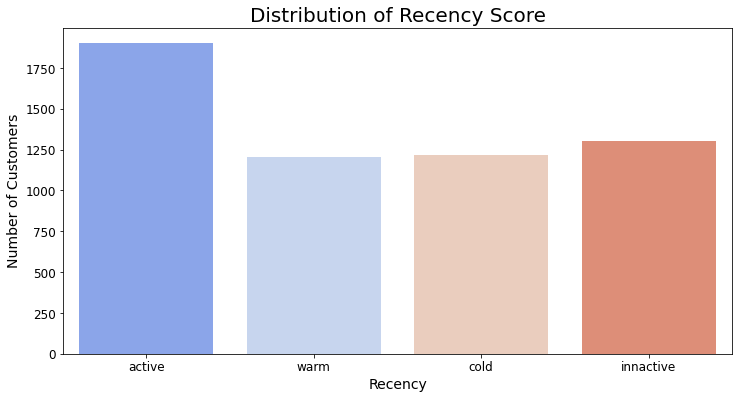

In [122]:

# Distribution of Recency
plt.figure(figsize=(12, 6))
sns.barplot(x='R_group', y='n_customers', data=df_R, palette='coolwarm')
plt.title('Distribution of Recency Score',fontsize=20)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Based on the graph above, the majority of e-commerce customers are in the **Active segment**. This means that they have been actively making transactions for **less than 2 days** since their last transaction.

Segmentation based on recency is important because the more recently a customer has made a transaction on e-commerce, the greater the tendency that they will remember e-commerce and make another transaction, as in the Active segment.

#### Frequency Segmentation
Frequency is a calculation of how often a customer makes a transaction. Segmentation based on frequency is done by creating 4 groups by sorting the frequency of each customer and then dividing it by 4 equally, this method is used because the majority of customers only make transactions once so the value will tend to the most. The names of the segmentations are low frequency, medium frequency, high frequency, and special frequency.

**Scoring**

In [127]:
# Frequency segmentation
def F_segmentation(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4

rfm_df['F'] = rfm_df['frequency'].apply(F_segmentation)
rfm_df['F'].value_counts()

2    2283
1    1751
4    1225
3     371
Name: F, dtype: int64

In [131]:
rfm_df["F"].unique()

array([1, 4, 2, 3], dtype=int64)

In [132]:
# Group by F
df_F = rfm_df.groupby(['F']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop = False)

# Name the F segmentation
df_F.loc[df_F['F'] == 4, 'F_group'] = 'special'
df_F.loc[df_F['F'] == 3, 'F_group'] = 'high'
df_F.loc[df_F['F'] == 2, 'F_group'] = 'medium'
df_F.loc[df_F['F'] == 1, 'F_group'] = 'low'

# Calculate the percentage
df_F['F_percent'] = round(df_F['n_customers']/df_F['n_customers'].sum()*100, 2)

df_F

F  n_customers  F_group  F_percent
0  1         1751      low      31.10
1  2         2283   medium      40.55
2  3          371     high       6.59
3  4         1225  special      21.76

- Special Frequency : More than 4 times making transactions
- High Frequency : 3 times making transactions
- Medium Frequency : 2 times making transactions
- Low Frequency : Only 1 time making transactions

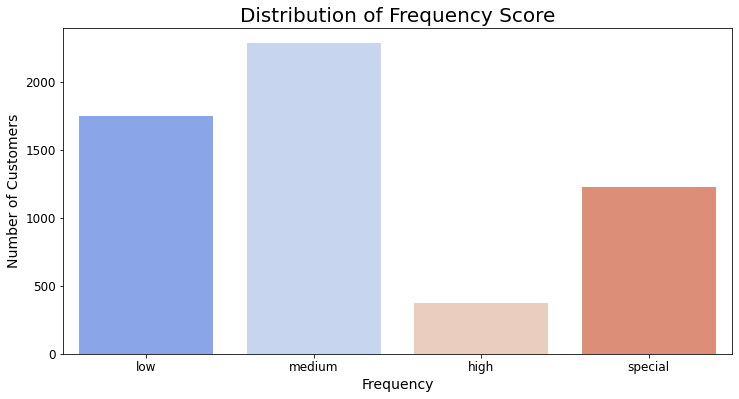

In [135]:
# Distribution of Frquency
plt.figure(figsize=(12, 6))
sns.barplot(x='F_group', y='n_customers', data=df_F, palette='coolwarm')
plt.title('Distribution of Frequency Score',fontsize=20)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

1. Special Frequency: There are 1225 or 21.76% of customers who make more than 4 transactions
2. High Frequency: There are 371 or 6.59% of customers who make transactions 3 times.
3. Medium Frequency: There are 2283 or 40.55% of customers who make transactions 2 times
4. Low Frequency: There are 1751 or 31.10% of customers who make transactions 1 time
> The majority of e-commerce customers are in the Medium Frequency segment, which means they only make transactions 2 times.

By segmenting based on frequency, we can see which customers use e-commerce repeatedly to make transactions or in other words loyal customers.

#### Monetary Segmentation
Monetary is the spending power or total purchase of a customer. Segmentation based on monetary is done by creating groups based on quartile values ​​(Q1, Q2, and Q3) so that there are 4 groups. The names of the segmentation are low value, medium value, high value, and special value.

**Scoring**


In [139]:
# Calculate Q1, Q2, Q3 from Monetary
round(rfm_df['monetary'].quantile([0.25, 0.5, 0.75]))

0.25    146.0
0.50    163.0
0.75    196.0
Name: monetary, dtype: float64

In [142]:
# Scoring for M values
labels_m = range(1, 5)
group_m = pd.qcut(rfm_df['monetary'], q = 4, labels = labels_m)
rfm_df['M'] = group_m.values

In [143]:
rfm_df["M"].unique()

[2, 1, 4, 3]
Categories (4, int64): [1 < 2 < 3 < 4]

In [144]:
# Group by M
df_M = rfm_df.groupby(['M']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop = False)

# Name the M Segmentation
df_M.loc[df_M['M'] == 1, 'M_group'] = 'low values'
df_M.loc[df_M['M'] == 2, 'M_group'] = 'medium values'
df_M.loc[df_M['M'] == 3, 'M_group'] = 'high values'
df_M.loc[df_M['M'] == 4, 'M_group'] = 'special values'

# Calculate the percentage
df_M['M_percent'] = round(df_M['n_customers']/df_M['n_customers'].sum()*100, 2)

df_M
     

M  n_customers         M_group  M_percent
0  1         1409      low values      25.03
1  2         1406   medium values      24.97
2  3         1407     high values      24.99
3  4         1408  special values      25.01

- Special Values = Monetary is more than R196 (Q3)
- High Values = Monetary is between R163(Q2) - R196
- Medium Values = Monetary is between R146(Q1) - R163
- Low Values = Monetary is less than R146

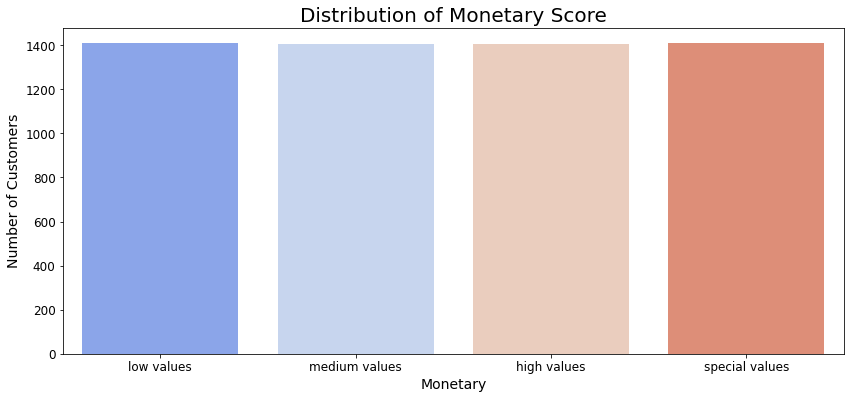

In [147]:
# Distribution of Monetary
plt.figure(figsize=(14, 6))
sns.barplot(x='M_group', y='n_customers', data=df_M, palette='coolwarm')
plt.title('Distribution of Monetary Score',fontsize=20)
plt.xlabel('Monetary',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

1. Special Values: There are 1408 or 25.01% of customers who make transactions with a total of more than 196
2. High Values: There are 1407 or 24.99% of customers who make transactions with a total of 163 - 196
3. Medium Values: There are 1406 or 24.97% of customers who make transactions with a total of 163 - 146
4. Low Values: There are 1409 or 25.03% of customers who make transactions with a total of less than 146

The monetary value of each segment has the same percentage value

Based on the graph above, we can see the division of customer segmentation based on their monetary value. There are 4 segments, namely:

By segmenting based on monetary, we can see which customers make the largest and smallest number of transactions. With that we can take a different marketing approach according to the segment.

#### Modelling

In this RFM Segmentation, we calculate the segmentation score by combining the scores of R, F, and M into a unique combination in the form of a string. For example, if R = 1, F = 1, and M = 1, then the RFM Segmentation Score becomes 1 + 1 + 1 = 111

**Calculate RFM Score**

In [152]:
# Combine the R, F, and M score
rfm_df['RFM Score'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)
rfm_df['RFM Score']

0       212
1       411
2       311
3       311
4       311
       ... 
5625    222
5626    324
5627    223
5628    123
5629    323
Name: RFM Score, Length: 5630, dtype: object

**RFM Segmentation based on RFM Score**

In [156]:
# RFM Segmentation 
def segmentation(x):
    if re.search('444', x) or re.search('344', x): 
        return 'Best'
    elif re.search('2.4', x) or re.search('3.4', x) or re.search('4.4', x):
        return 'Big Spender'
    elif re.search('24.', x) or re.search('34.', x) or re.search('23.', x) or re.search('33.', x):
        return 'Loyal'
    elif re.search('41.', x):
        return 'New'
    elif re.search('4..', x) or re.search('3..', x):
        return 'Promising'
    elif re.search('111', x) or re.search('211', x) or re.search('112', x) or re.search('212', x):
        return 'Lost'
    elif re.search('1..', x) or re.search('2..', x):
        return 'Lost Potential'
    else:
        return 'Reguler'

rfm_df['RFM Segment'] = rfm_df['RFM Score'].apply(segmentation)
rfm_df['RFM Segment'].value_counts()

Lost Potential    1671
Promising         1336
New                888
Big Spender        712
Loyal              501
Lost               346
Best               176
Name: RFM Segment, dtype: int64

In [157]:
# Customer Segmentation Percentage
round(rfm_df['RFM Segment'].value_counts(normalize=True)*100, 2)

Lost Potential    29.68
Promising         23.73
New               15.77
Big Spender       12.65
Loyal              8.90
Lost               6.15
Best               3.13
Name: RFM Segment, dtype: float64

In [158]:
rfm_agg = rfm_df.groupby('RFM Segment').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'monetary' : 'mean',
    'RFM Segment' : 'count'
})

rfm_agg.round(2)
     

recency  frequency  monetary  RFM Segment
RFM Segment                                              
Best               2.62       8.36    230.97          176
Big Spender        3.20       2.57    244.79          712
Lost               6.13       1.00    141.28          346
Lost Potential     8.46       4.21    195.30         1671
Loyal              4.85       4.84    158.28          501
New                1.01       1.00    138.12          888
Promising          2.08       2.01    153.93         1336

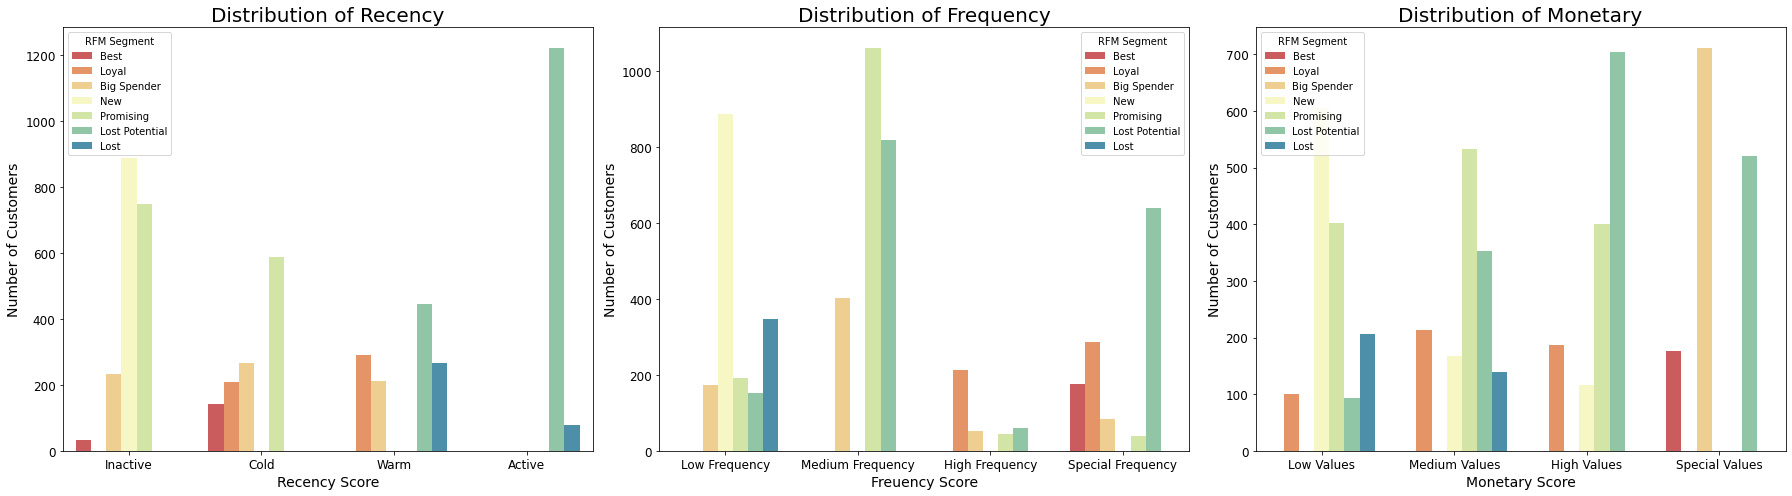

In [159]:
segment = ['Best', 'Loyal', 'Big Spender', 'New', 'Promising', 'Lost Potential', 'Lost']
# Visualization for Recency, Freuency, Monetary score distribution by Customer Segmentation 2
plt.figure(figsize=(25, 7))

plt.subplot(131)
sns.countplot(x='R', hue='RFM Segment', data=rfm_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Recency',fontsize=20)
plt.xlabel('Recency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Inactive', 'Cold', 'Warm', 'Active'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(132)
sns.countplot(x='F', hue='RFM Segment', data=rfm_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Frequency',fontsize=20)
plt.xlabel('Freuency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Frequency', 'Medium Frequency', 'High Frequency', 'Special Frequency'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(133)
sns.countplot(x='M', hue='RFM Segment', data=rfm_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Monetary',fontsize=20)
plt.xlabel('Monetary Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Values', 'Medium Values', 'High Values', 'Special Values'], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

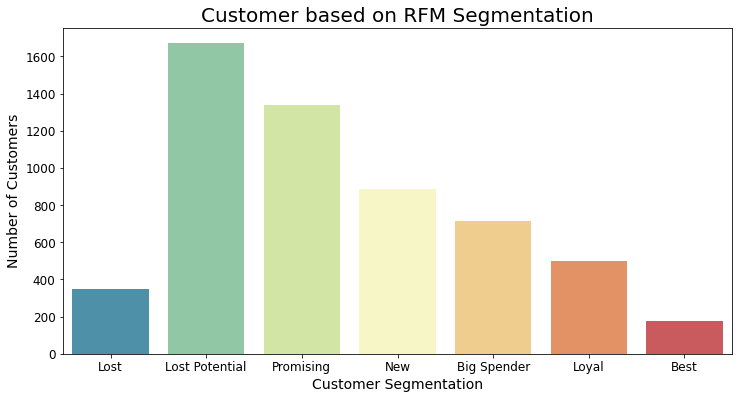

In [160]:
segment2 = ['Lost', 'Lost Potential', 'Promising', 'New', 'Big Spender', 'Loyal', 'Best']
# Distribution of Customer Segmentation
plt.figure(figsize=(12,6))
sns.countplot(x='RFM Segment', data=rfm_df, order=segment2, palette='Spectral_r')
plt.title('Customer based on RFM Segmentation',fontsize=20)
plt.xlabel('Customer Segmentation',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

1. Best: Customers who have made recent transactions, frequently make transactions, and have the highest total transactions.
2. Loyal: Customers who have made transactions more than 4 times.
3. Big Spender: Customers who have made transactions with the highest total transactions.
4. New: Customers who have made recent transactions and have only made 1 transaction.
5. Promising: Customers who have recently made transactions, and whose transaction frequency and total are above the average of other customers.
6. Lost Potential: Customers who have not made transactions for a long time, but whose transaction frequency and total are above the average of other customers.
7. Lost: Customers who have not made transactions for a long time, have only made one transaction, and whose transaction total is small.

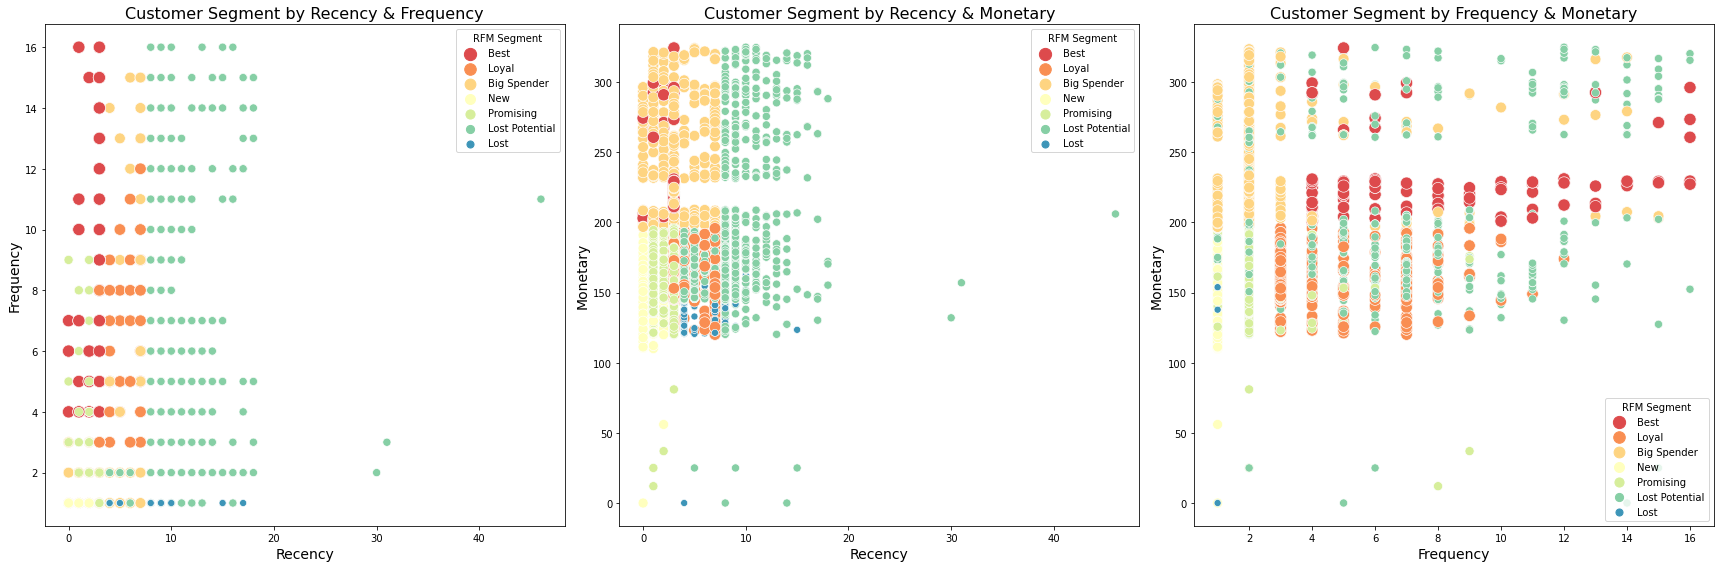

In [162]:
# Scatter Plot for RFM segmentation 2
plt.figure(figsize=(24,8), facecolor='w')

plt.subplot(131)
sns.scatterplot(x='recency', 
                y='frequency', 
                hue='RFM Segment', 
                data=rfm_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment, 
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Frequency',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(132)
sns.scatterplot(x='recency', 
                y='monetary', 
                hue='RFM Segment', 
                data=rfm_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Monetary',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(133)
sns.scatterplot(x='frequency', 
                y='monetary', 
                hue='RFM Segment', 
                data=rfm_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment,
                palette='Spectral')
plt.title('Customer Segment by Frequency & Monetary',fontsize=16)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [163]:
def RFM_segmentation_score(x):
    if x == 'Best':
        return 7
    elif x == 'Loyal':
        return 6
    elif x == 'Big Spender':
        return 5
    elif x == 'New':
        return 4
    elif x == 'Promising':
        return 3
    elif x == 'Lost Potential':
        return 2
    else:
        return 1

rfm_df['RFM Segment Score'] = rfm_df['RFM Segment'].apply(RFM_segmentation_score)
     

**Calucalate Silhoutte Score**

In [174]:
# Define x
x = rfm_df[['recency', 'frequency', 'monetary']]
# Scale
scaler = StandardScaler()
# Data Scale
x_scaled = scaler.fit_transform(x)
# Calculate Silhoutte Score
labels = rfm_df['RFM Segment Score']
silhoutte_value = silhouette_score(x_scaled, labels)
print('Silhoutte Score for RFM:', silhoutte_value)

Silhoutte Score for RFM: 0.06673593068641394


### K-Means:
K-Means is an algorithm that can be used for clustering. The K-Means algorithm uses the same distance concept as the KNN algorithm. One of the distance concepts used is Euclidean. Because the K-Means algorithm uses the distance concept, we have to scale the features we have because the scaling of the features is not the same. The features we have show outliers and we do not want the outlier data to have an effect so the scaling that can be used is the Standard Scaler.

In [176]:
## Data
x = rfm_df[['recency', 'frequency', 'monetary']]

# Scale
scaler = StandardScaler()

# Data Scale
x_scaled = scaler.fit_transform(x)

In [179]:
score = []
number_of_clusters = range(2,9)

for i in number_of_clusters:
  kmeans = KMeans(i)
  kmeans.fit(x_scaled)

  label = kmeans.labels_
  score.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

In [181]:
for i in range(len(score)):
  print(f'Silhoutte Score for {i+2} Cluster', round(score[i], 3))

Silhoutte Score for 2 Cluster 0.452
Silhoutte Score for 3 Cluster 0.412
Silhoutte Score for 4 Cluster 0.429
Silhoutte Score for 5 Cluster 0.453
Silhoutte Score for 6 Cluster 0.441
Silhoutte Score for 7 Cluster 0.339
Silhoutte Score for 8 Cluster 0.344


Text(0, 0.5, 'Silhoutte Score')

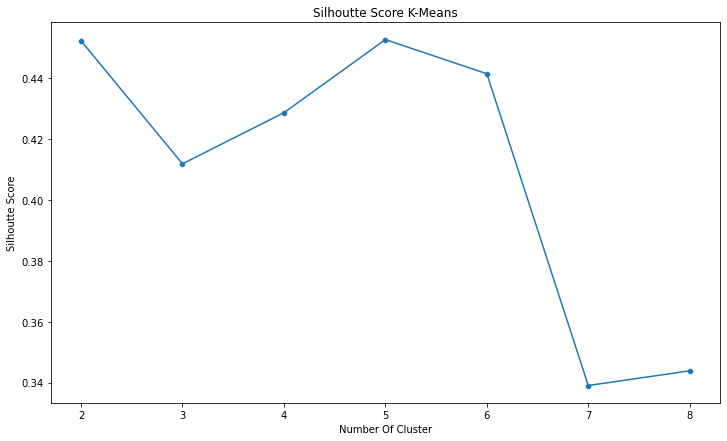

In [182]:
plt.figure(figsize = (12, 7))

sns.lineplot(number_of_clusters, score)
sns.scatterplot(number_of_clusters, score)

plt.title('Silhoutte Score K-Means')
plt.xlabel("Number Of Cluster")
plt.ylabel('Silhoutte Score')

The best Silhoutte Score is obtained in cluster 2
We decided not to use 2 clusters because the clusters that are formed are most likely only customers with a frequency of 1 time with low monetary and customers outside the cluster
We will use 5 clusters because 5 clusters have the highest silhouette score after 2

In [184]:
kmeans = KMeans(n_clusters=5, random_state=10)
kmeans.fit(x_scaled)

rfm_df['label k-means'] = kmeans.labels_

label = rfm_df['label k-means']
score = silhouette_score(x_scaled, label, metric = 'euclidean')
score

0.4501646972729387

In [186]:
def label(x):
  if x == 0:
    return 'New Comer'
  elif x == 1:
    return 'Lost'
  elif x == 2:
    return 'Big Spender'
  elif x == 3:
    return 'Medium Spender'
  else:
    return 'Loyal'

rfm_df['label k-means'] = rfm_df['label k-means'].apply(label)

# Number of Customers per segment
rfm_df['label k-means'].value_counts()

Lost              2998
New Comer          958
Medium Spender     784
Loyal              634
Big Spender        256
Name: label k-means, dtype: int64

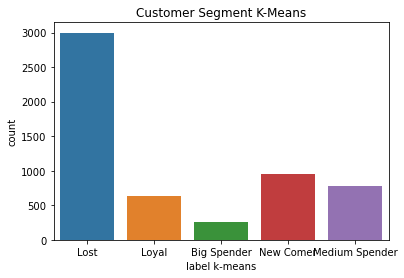

In [187]:
## Viz
plt.figure(figsize = (6,4))
sns.countplot(x='label k-means', data = rfm_df)
plt.title('Customer Segment K-Means')
plt.show()

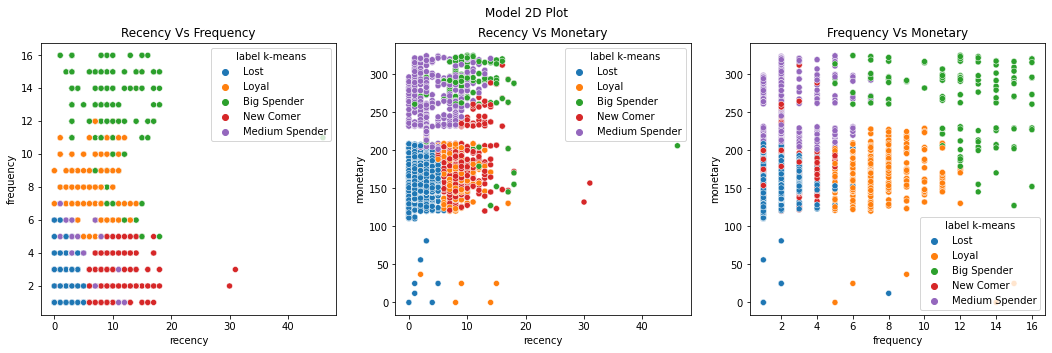

In [188]:
plt.figure(figsize =(18,5))

# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'label k-means', data = rfm_df)
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'label k-means', data = rfm_df)
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'label k-means', data = rfm_df)
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.show()

### Segmentation Analysis
The next stage is to analyze the nature of each segmentation so that treatment can be given that is appropriate to that nature.

In [190]:
# RFM Segmentation Group by for analysis
rfm_segment = rfm_df.groupby(['RFM Segment', 'RFM Segment Score']).agg(
    n_customer = ('CustomerID', 'count'),
    mean_recency =  ('recency', 'mean'),
    min_recency = ('recency', 'min'),
    max_rencency = ('recency', 'max'),
    mean_freq = ('frequency', 'mean'),
    min_freq = ('frequency', 'min'),
    max_freq = ('frequency', 'max'),
    mean_monetary =  ('monetary', 'mean'),
    min_monetary = ('monetary', 'min'),
    max_monetary = ('monetary', 'max'),
    most_payment_type = ('PreferredPaymentMode', lambda x: x.value_counts().index[0]),
    avg_review_score = ('SatisfactionScore', 'mean'),
    most_product_buy = ('PreferedOrderCat', lambda x: x.value_counts().index[0]),
).sort_values(by='RFM Segment Score', ascending=False)

rfm_segment

n_customer  mean_recency  min_recency  \
RFM Segment    RFM Segment Score                                          
Best           7                         176      2.625000          0.0   
Loyal          6                         501      4.846307          3.0   
Big Spender    5                         712      3.200843          0.0   
New            4                         888      1.010135          0.0   
Promising      3                        1336      2.079341          0.0   
Lost Potential 2                        1671      8.461999          4.0   
Lost           1                         346      6.132948          4.0   

                                  max_rencency  mean_freq  min_freq  max_freq  \
RFM Segment    RFM Segment Score                                                
Best           7                           3.0   8.357955       4.0      16.0   
Loyal          6                           7.0   4.842315       3.0      12.0   
Big Spender    5                           7.0   2.567416       1.0      15.0   
New            4                           2.0   1.000000       1.0       1.0   
Promising      3                           3.0   2.006737       1.0       9.0   
Lost Potential 2                          46.0   4.210054       1.0      16.0   
Lost           1                          17.0   1.000000       1.0       1.0   

                                  mean_monetary  min_monetary  max_monetary  \
RFM Segment    RFM Segment Score                                              
Best           7                     230.968920        200.96        324.43   
Loyal          6                     158.280918        120.11        196.19   
Big Spender    5                     244.787219        196.67        324.26   
New            4                     138.116137          0.00        196.10   
Promising      3                     153.928451         12.00        196.37   
Lost Potential 2                     195.301556          0.00        324.99   
Lost           1                     141.281647          0.00        163.22   

                                 most_payment_type  avg_review_score  \
RFM Segment    RFM Segment Score                                       
Best           7                        Debit Card          3.051136   
Loyal          6                        Debit Card          2.972056   
Big Spender    5                        Debit Card          3.005618   
New            4                        Debit Card          3.087838   
Promising      3                        Debit Card          3.058383   
Lost Potential 2                        Debit Card          3.115500   
Lost           1                       Credit Card          3.080925   

                                    most_product_buy  
RFM Segment    RFM Segment Score                      
Best           7                             Fashion  
Loyal          6                  Laptop & Accessory  
Big Spender    5                             Fashion  
New            4                        Mobile Phone  
Promising      3                        Mobile Phone  
Lost Potential 2                  Laptop & Accessory  
Lost           1                  Laptop & Accessory

Text(0.5, 1.0, 'Recency per RFM Segment')

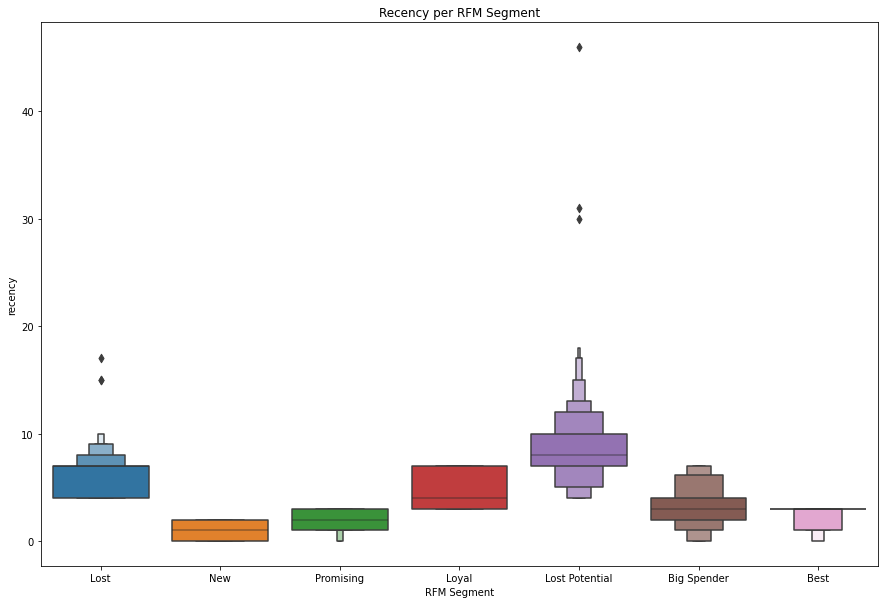

In [192]:
plt.figure(figsize=(15,10))
sns.boxenplot(x=rfm_df['RFM Segment'], y=rfm_df['recency'])
plt.title('Recency per RFM Segment')

Text(0.5, 1.0, 'Frequency per RFM Segment')

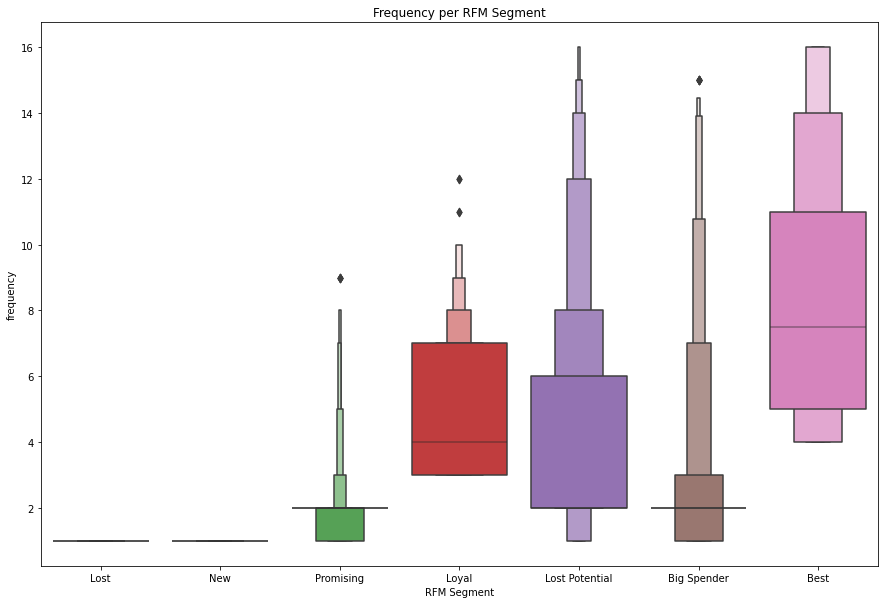

In [193]:
plt.figure(figsize=(15,10))
sns.boxenplot(x=rfm_df['RFM Segment'], y=rfm_df['frequency'])
plt.title('Frequency per RFM Segment')

Text(0.5, 1.0, 'Monetary per RFM Segment')

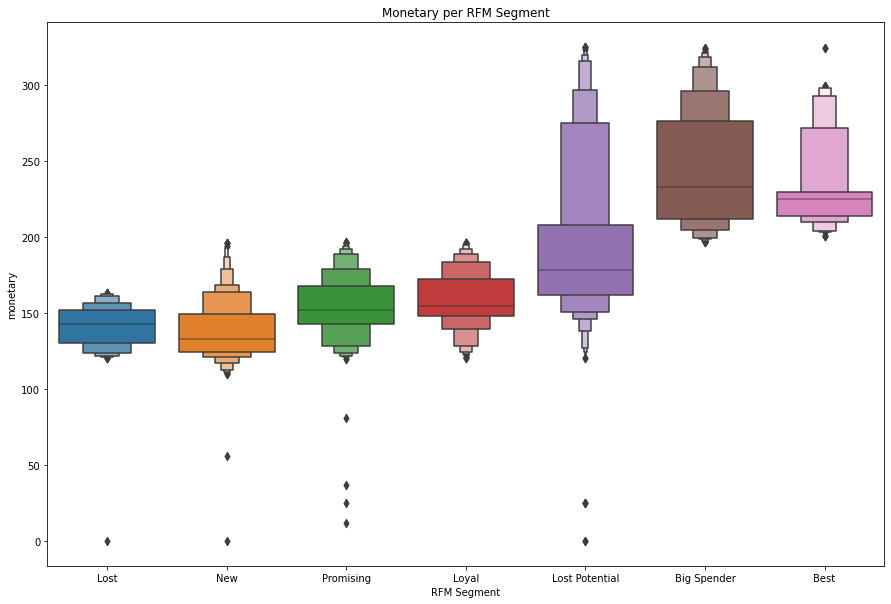

In [194]:
plt.figure(figsize=(15,10))
sns.boxenplot(x=rfm_df['RFM Segment'], y=rfm_df['monetary'])
plt.title('Monetary per RFM Segment')

## Insights

1. **Best Customers:**
- This segment consists of 176 customers
- Customers can be said to be Best Customers who have made recent transactions, often make transactions, and have the highest total transactions.
- In this segment, the average total transaction for each customer is around \\$231 with an average transaction frequency of 8 times, and an average last purchase time of around 2.6 days.
- Customers in this segment give an average review score of 3.1
- In this segment, customers mostly buy the Fashion category with credit card payment methods.
- The treatments provided are loyalty programs/reward points, new product recommendations, and exclusive product offers. (Cross/Up Selling Strategy)

2. **Loyal:**
- This segment consists of 501 customers
- Customers who make the most frequent transactions.
- In this segment, the average total transaction for each customer is around \\$158 with an average transaction frequency of 5 times, and an average last purchase time of around 4.8 days.
- Customers in this segment gave an average review score of 2.9
- In this segment, customers mostly buy the Laptop & Accessory category with credit card payment method.
- The treatment given is loyalty program/reward point and exclusive goods offer (Cross/Up Selling Strategy).

3. **Big Spender:**
- This segment consists of 712 customers
- Customers who have the highest total transactions.
- In this segment, the average total transaction for each customer is around \\$245 with an average transaction frequency of 3 times, and an average last purchase time of around 3 days.
- Customers in this segment gave an average review score of 3
- In this segment, customers mostly buy the Fashion category with credit card payment method.
- The treatment that can be given is exclusive goods recommendation, partnership/membership offer (B2B), and purchase offer at wholesale price (Cross/Up Selling Strategy)

4. **New:**
- This segment consists of 888 customers
- Customers who have recently made a transaction and have only made one transaction.
- In this segment, the average total transaction for each customer is around \\$138 with an average transaction frequency of 1 time, and an average last purchase time of around 1 day.
- Customers in this segment give an average review score of 3.1
- In this segment, customers mostly buy the Mobile Phone category with the credit card payment method.
- Treatments that can be given are welcome emails to build relationships, loyalty program/reward point offers, and discount vouchers (Cross/Up Selling Strategy)

5. **Promising:**
- This segment consists of 1336 customers
- Customers who have recently made transactions, and their transaction frequency and total are above the average of other customers.
- In this segment, the average total transaction for each customer is around \\$153 with an average transaction frequency of 2 times, and an average last purchase time of around 2 days.
- Customers in this segment give an average review score of 3.1
- In this segment, customers mostly buy the Mobile Phone category with the credit card payment method.
- Treatments that can be given are regular limited offers, discount vouchers and cashback via e-mail (Retention Strategy)

6. **Lost Potential:**
- This segment consists of 1671 customers
- Customers who have not made a transaction for a long time, but the frequency and total transactions are above the average of other customers.
- In this segment, the average total transaction for each customer is around \\$195 with an average transaction frequency of 4 times, and an average last purchase time of around 8.4 days.
- Customers in this segment give an average review score of 3.1
- In this segment, customers mostly buy the Laptop & Accessory category with the credit card payment method.
- Treatments that can be given are regular limited offers, discount vouchers and cashback via e-mail (Retention & Reactivate Strategies)

7. **Lost:**
- This segment consists of 346 customers
- Customers who have not made a transaction for a long time, have only made one transaction, and the total transaction is small.
- In this segment, the average total transaction for each customer is around \\$141 with an average transaction frequency of 1 time, and an average last purchase time of around 6 days.
- Customers in this segment give an average review score of 3.1
- In this segment, customers mostly buy the Laptop & Accessory category with the credit card payment method.
- Treatments that can be given are campaigns via e-mail and asking for feedback. (Reactivation Strategy)

Based on the 3 models, each model has its own weaknesses and advantages:
1. **RFM Segmentation**:
- *Advantages*:
    - This model is the model that has the highest interpretation compared to other models, because this model is made with the domain knowledge that we have
- *Disadvantages*:
    - When measured quantitatively with a silhouette score, this model is the lowest model
2. **K-Means:**
- *Advantages:*
    - The K-Means model is a model that is not too bad visually and is not too bad in terms of silhouette score either.
- *Disadvantages:*
    - In the K-Means model segmentation, there are several customers whose segmentation is not specific enough, because the number of clusters is only determined from the Silhouette Score.

>**Conclusion:**
Model RFM Segmentation divides the dataset into 7 clusters: Best, Loyal, Big Spender, New, Promising, Lost Potential, and Lost

## Business Recommendation
  
| RFM Segment | Strategy | Description |
|-------------|----------|-------------|
| Best        | Loyalty program/reward points, new product recommendations, and exclusive product offers (Cross / Up Selling Strategy) | Customers who have recently made transactions, frequently make transactions, and have the highest total transactions. |
| Loyal       | Loyalty program/reward points and exclusive product offers (Cross / Up Selling Strategy) | Customers who make the most frequent transactions. |
| Big Spender | Exclusive product recommendations, partnership/membership (B2B) offers, and wholesale purchase offers (Cross / Up Selling Strategy) | Customers who have the highest total transactions. |
| New         | Welcome email to build relationships, loyalty program/reward points offers, and discount vouchers (Cross / Up Selling Strategy) | Customers who have recently made transactions and have only made one transaction. |
| Promising   | Regular limited offers, discount vouchers and cashback via e-mail (Retention Strategy) | Customers who have recently made transactions, and whose transaction frequency and total are above the average of other customers. |
| Lost Potential | Regular limited offers, discount vouchers and cashback via e-mail (Retention & Reactivate Strategies) | Customers who have not made a transaction for a long time, but the frequency and total transactions are above the average of other customers. |
| Lost        | Campaign via e-mail and asking for feedback. (Reactivation Strategy) | Customers who have not made a transaction for a long time, have only made one transaction, and the total transaction is small. |
